In [1]:
import sklearn
import numpy as np
import pandas as pd
from sklearn.model_selection import cross_validate
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.tree import export_graphviz
import matplotlib.pyplot as plt
import seaborn as sns
import graphviz
from sklearn.metrics import confusion_matrix
from minio import Minio
import pickle


In [2]:
df = pd.read_csv('db.csv')

In [3]:
df.head()

,Age,Sex,Chest pain type,BP,Cholesterol,FBS over 120,EKG results,Max HR,Exercise angina,ST depression,Slope of ST,Number of vessels fluro,Thallium,Heart Disease
0,70,1,4,130,322,0,2,109,0,2.4,2,3,3,Presence
1,67,0,3,115,564,0,2,160,0,1.6,2,0,7,Absence
2,57,1,2,124,261,0,0,141,0,0.3,1,0,7,Presence
3,64,1,4,128,263,0,0,105,1,0.2,2,1,7,Absence
4,74,0,2,120,269,0,2,121,1,0.2,1,1,3,Absence


In [4]:
df.isnull().sum()

Age                        0
Sex                        0
Chest pain type            0
BP                         0
Cholesterol                0
FBS over 120               0
EKG results                0
Max HR                     0
Exercise angina            0
ST depression              0
Slope of ST                0
Number of vessels fluro    0
Thallium                   0
Heart Disease              0
dtype: int64

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 270 entries, 0 to 269
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Age                      270 non-null    int64  
 1   Sex                      270 non-null    int64  
 2   Chest pain type          270 non-null    int64  
 3   BP                       270 non-null    int64  
 4   Cholesterol              270 non-null    int64  
 5   FBS over 120             270 non-null    int64  
 6   EKG results              270 non-null    int64  
 7   Max HR                   270 non-null    int64  
 8   Exercise angina          270 non-null    int64  
 9   ST depression            270 non-null    float64
 10  Slope of ST              270 non-null    int64  
 11  Number of vessels fluro  270 non-null    int64  
 12  Thallium                 270 non-null    int64  
 13  Heart Disease            270 non-null    object 
dtypes: float64(1), int64(12), 

In [6]:
seed = 1580
x = df.drop(columns= 'Heart Disease')
y = df['Heart Disease'].map({'Presence': 1, 'Absence' : 0})

np.random.seed(seed)
treino_x, teste_x, treino_y, teste_y = train_test_split(x,y,random_state = seed, stratify = y, test_size = 0.3)
print("Treino com %d e teste com %d" % (len(treino_x), len(teste_x)))

Treino com 189 e teste com 81


In [7]:
dummy = DummyClassifier()
dummy.fit(treino_x,treino_y)
acc = dummy.score(teste_x, teste_y) * 100
print("acuracia dummy %.2f%%" % acc)

acuracia dummy 55.56%


In [8]:
from sklearn.tree import DecisionTreeClassifier
# from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

modelo = DecisionTreeClassifier(max_depth = 3)
modelo.fit(treino_x, treino_y)
previsoes = modelo.predict(teste_x)

acc = accuracy_score(teste_y, previsoes) * 100
print("acuracia %.2f%%" % acc)

acuracia 62.96%


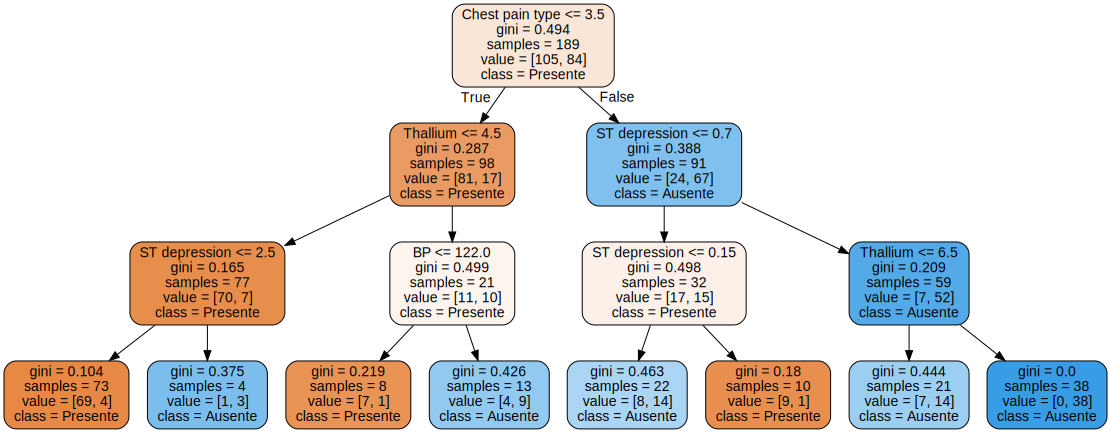

In [9]:
features = x.columns
data_tabela = export_graphviz(modelo, out_file = None,
                              filled = True,
                              rounded = True,
                              feature_names = features,
                              class_names = ['Presente', 'Ausente'])
grafico = graphviz.Source(data_tabela)
grafico

<AxesSubplot:>

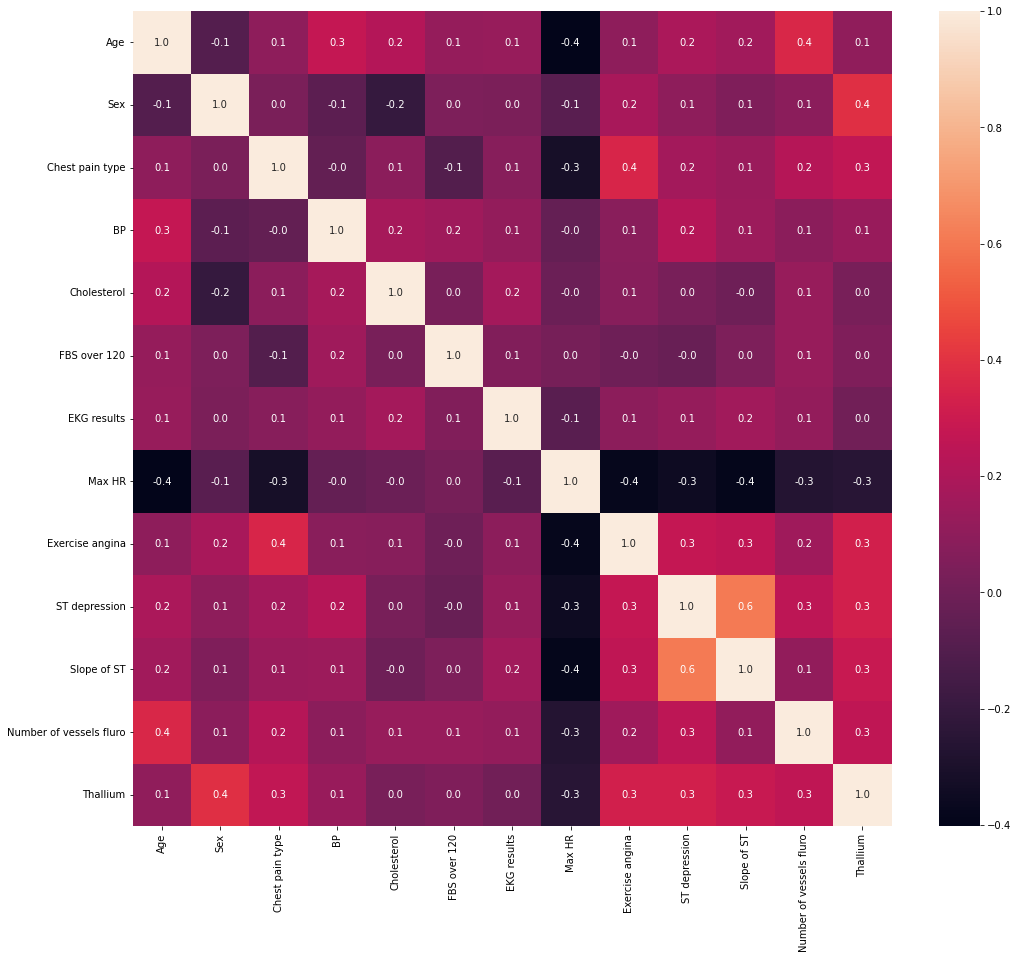

In [10]:
matriz_corr = df.corr()
plt.figure(figsize = (17,15))
sns.heatmap(matriz_corr, annot = True, fmt = ".1f")

In [11]:
modelo1 = RandomForestClassifier(max_depth = 3,
                                n_estimators = 100)
modelo.fit(treino_x, treino_y)
previsoes = modelo.predict(teste_x)

acc = accuracy_score(teste_y, previsoes) * 100
print("acuracia %.2f%%" % acc)

acuracia 62.96%


<AxesSubplot:>

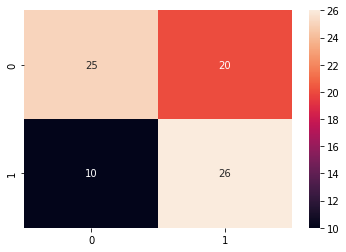

In [12]:
matriz_confusao = confusion_matrix(teste_y, previsoes)
sns.heatmap(matriz_confusao, annot = True, fmt = "d")

<AxesSubplot:xlabel='Heart Disease', ylabel='count'>

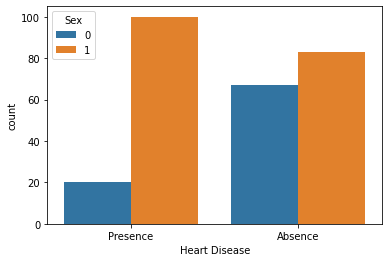

In [13]:
sns.countplot(x = "Heart Disease", hue = "Sex", data=df)

In [14]:
def imprime_resultados(results):
    media = results['test_score'].mean()
    desvio_padrao = results['test_score'].std()
    print("Acuracia médio: %.2f" % (media * 100))
    print("Acuracia com cross validation 10 = [%.2f%% ~ %.2f%%]" % ((media - 2 * desvio_padrao)*100, (media + 2 * desvio_padrao) * 100))

In [16]:
cv = KFold(n_splits = 10, shuffle = True)
modelo = RandomForestClassifier(max_depth = 3, n_estimators = 100)

seed = 1580
np.random.seed(seed)

x = df.drop(columns= 'Heart Disease')
y = df['Heart Disease'].map({'Presence': 1, 'Absence' : 0})

results = cross_validate(modelo,x,y,cv = cv, return_train_score = False)
imprime_resultados(results)

Acuracia médio: 84.44
Acuracia com cross validation 10 = [73.56% ~ 95.33%]


In [17]:
modelo.fit(x,y)

RandomForestClassifier(max_depth=3)

In [18]:
df

,Age,Sex,Chest pain type,BP,Cholesterol,FBS over 120,EKG results,Max HR,Exercise angina,ST depression,Slope of ST,Number of vessels fluro,Thallium,Heart Disease
0,70,1,4,130,322,0,2,109,0,2.4,2,3,3,Presence
1,67,0,3,115,564,0,2,160,0,1.6,2,0,7,Absence
2,57,1,2,124,261,0,0,141,0,0.3,1,0,7,Presence
3,64,1,4,128,263,0,0,105,1,0.2,2,1,7,Absence
4,74,0,2,120,269,0,2,121,1,0.2,1,1,3,Absence
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
265,52,1,3,172,199,1,0,162,0,0.5,1,0,7,Absence
266,44,1,2,120,263,0,0,173,0,0.0,1,0,7,Absence
267,56,0,2,140,294,0,2,153,0,1.3,2,0,3,Absence
268,57,1,4,140,192,0,0,148,0,0.4,2,0,6,Absence


In [19]:
pickle.dump(modelo, open('/Users/Qorpo/Desktop/Jupyter/modelo.pkl', 'wb'))